<a href="https://colab.research.google.com/github/evmpython/CAT212_2025/blob/main/CAT212_Aula_01_Radiossondagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disciplina:** CAT212 - Microfísica de Nuvens e Eletricidade Atmosférica
---





## **Aula Prática 1:** $\underline{Trabalhando\ com\ dados\ de\ Radiossondagens}$

---


**OBJETIVO:** Nesta aula prática aprenderemos como baixar  e plotar dados de radiossondagens. Para isto será utilizado os dados da Universidade de [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).



---


**DADOS DE ENTRADA**: Arquivos texto de radiossondagem.

- **Tipo do dado:** tabela  
- **Formato do dado:** arquivo TEXTO
- **Nome do arquivo:** Não tem
- **Fonte dos dados:** http://weather.uwyo.edu/upperair/sounding.html



---

**DADOS DE SAÍDA:** Figura e arquivo CSV
- **Tipo do dado:** Figura e tabela
- **Formato do dado:** arquivo JPG e CSV
- **Imagens geradas:**
    1. skewt_SBGL_2022-10-30 12:00:00.jpg
    2. SBGL_2022-10-30 12:00:00.csv



---



**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:

1.   Download dos dados de uma sondagem atmosférica para uma determinada data/horário
2.   Tratamento dos dados (eliminação de dados ausentes)
3.   Cálculo dos índices termodinâmicos
4.   Plotagem do Skew-T Log-P com a Hodógrafa
5.   Salvar os dados em arquivo csv


---




**OBSERVAÇÕES IMPORTANTES**:
1. Mudar o caminho para o do seu drive.
2. Escolher a estação de radiossondagem. A escolha pode ser realizada inserindo o `código númerico` ou a `sigla` da estação.
3. Escolher a `data/horário` da radiossondagem.



---

- **Realizado por:** [Willy Hagi](https://taggo.one/willyhagi) da Meteonorte
- **Atualizado por:** Enrique V. Mattos - 22/10/2021, Atualizado em: 18/03/2025

---


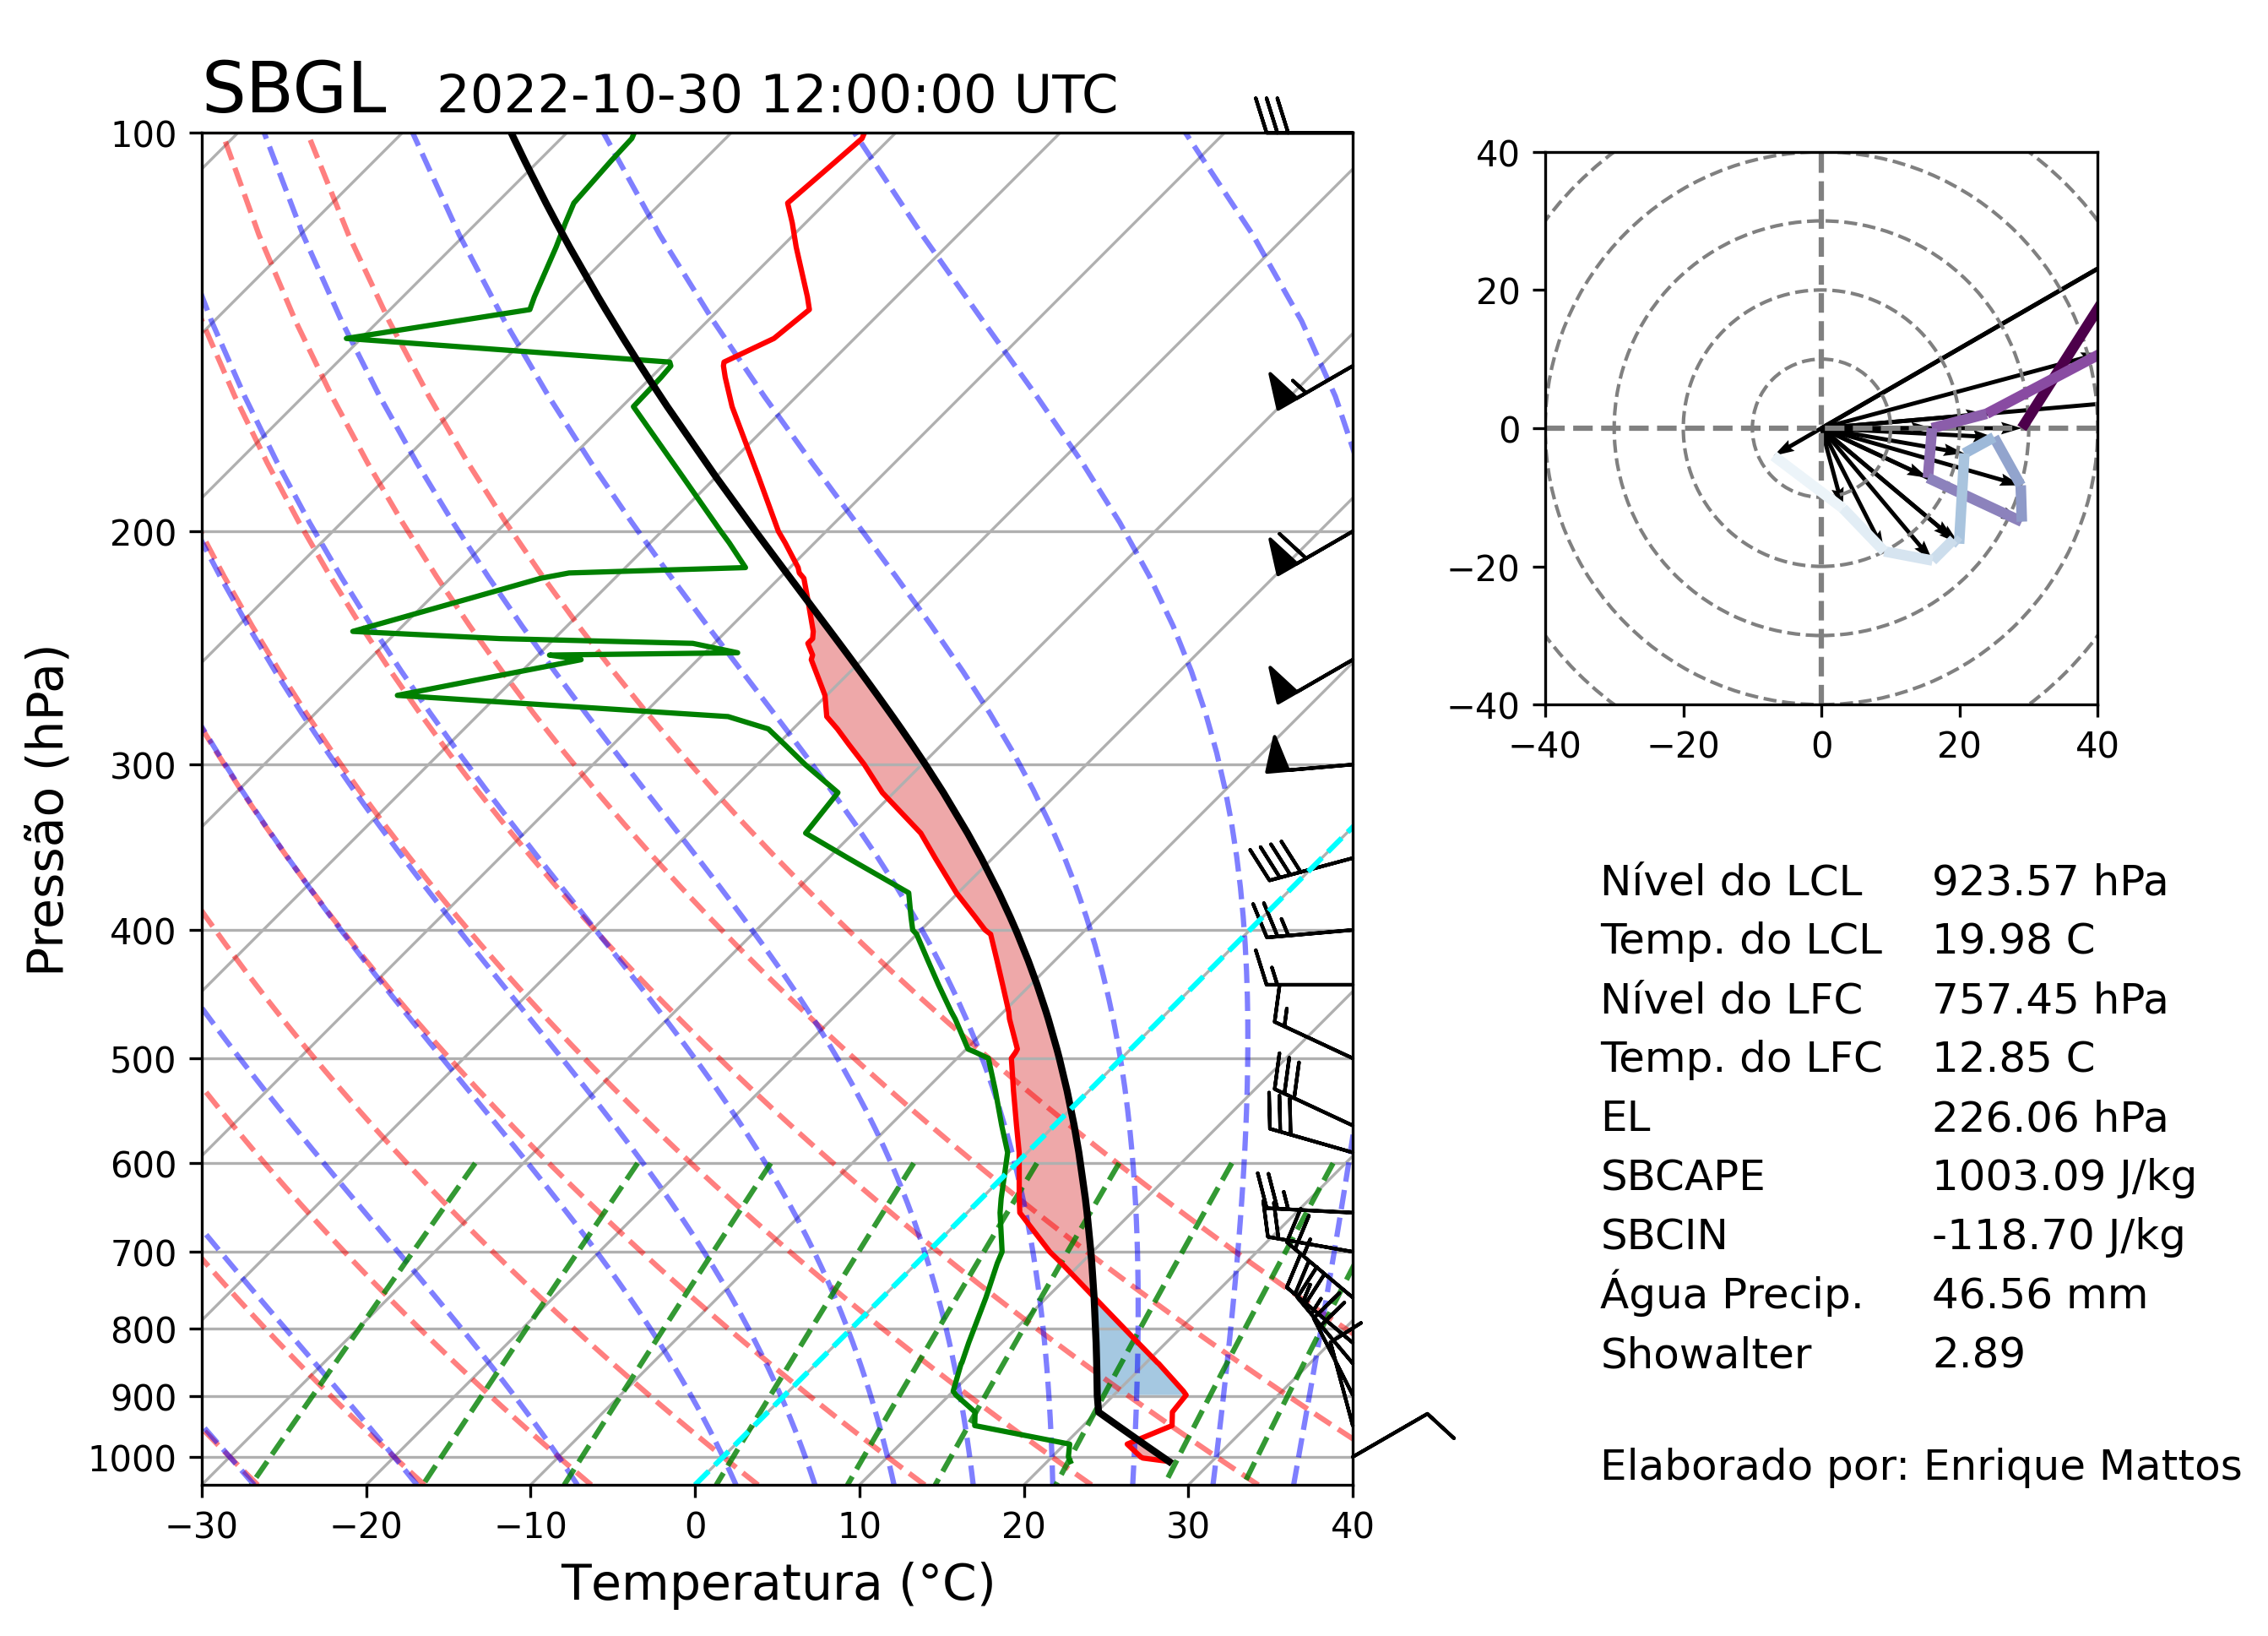

# **1° Passo:** Instalando o `Siphon`
O [`Siphon`](https://github.com/Unidata/siphon) é um pacote que reúne uma coleção de funcionalidades que permitem o acesso de alguns bancos de dados meteorológicos. Para a nossa aula prática, vamos acessar o banco de dados de radiossondagens mantido pela [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).

Outros bancos de dados:
* *Integrated Global Radiosonde Archive version 2* (IGRA v2);
* *Iowa State’s upper air archive*;
* *National Data Buoy Center* (NDBC).

Vamos instalar o `Siphon` no **Colab**:

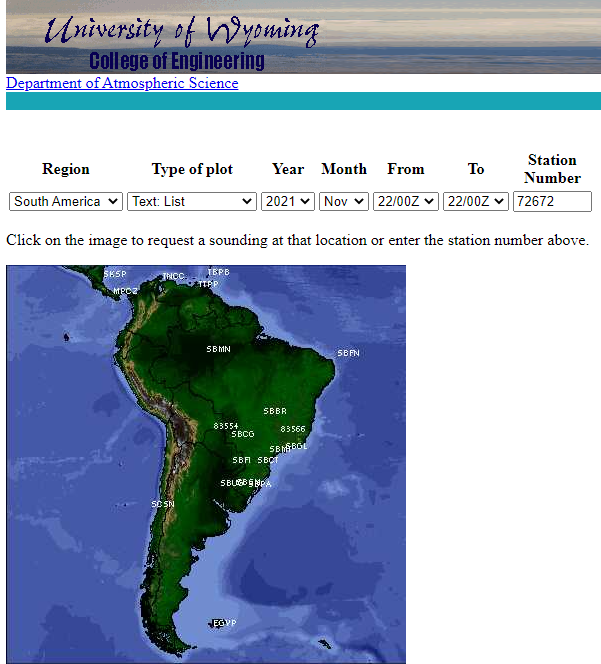

In [ ]:
!pip install siphon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 2.3 MB/s eta 0:00:00


# **2° Passo:** Instalando o `MetPy`
O [`MetPy`](https://unidata.github.io/MetPy/latest/index.html) foi um dos primeiros pacotes voltados exclusivamente para meteorologia no ecossistema científico do Python. É mantido até hoje pela UCAR/UNIDATA e por uma série de pesquisadores/programadores voluntários.

Vamos instalar o `MetPy` no **Colab**:

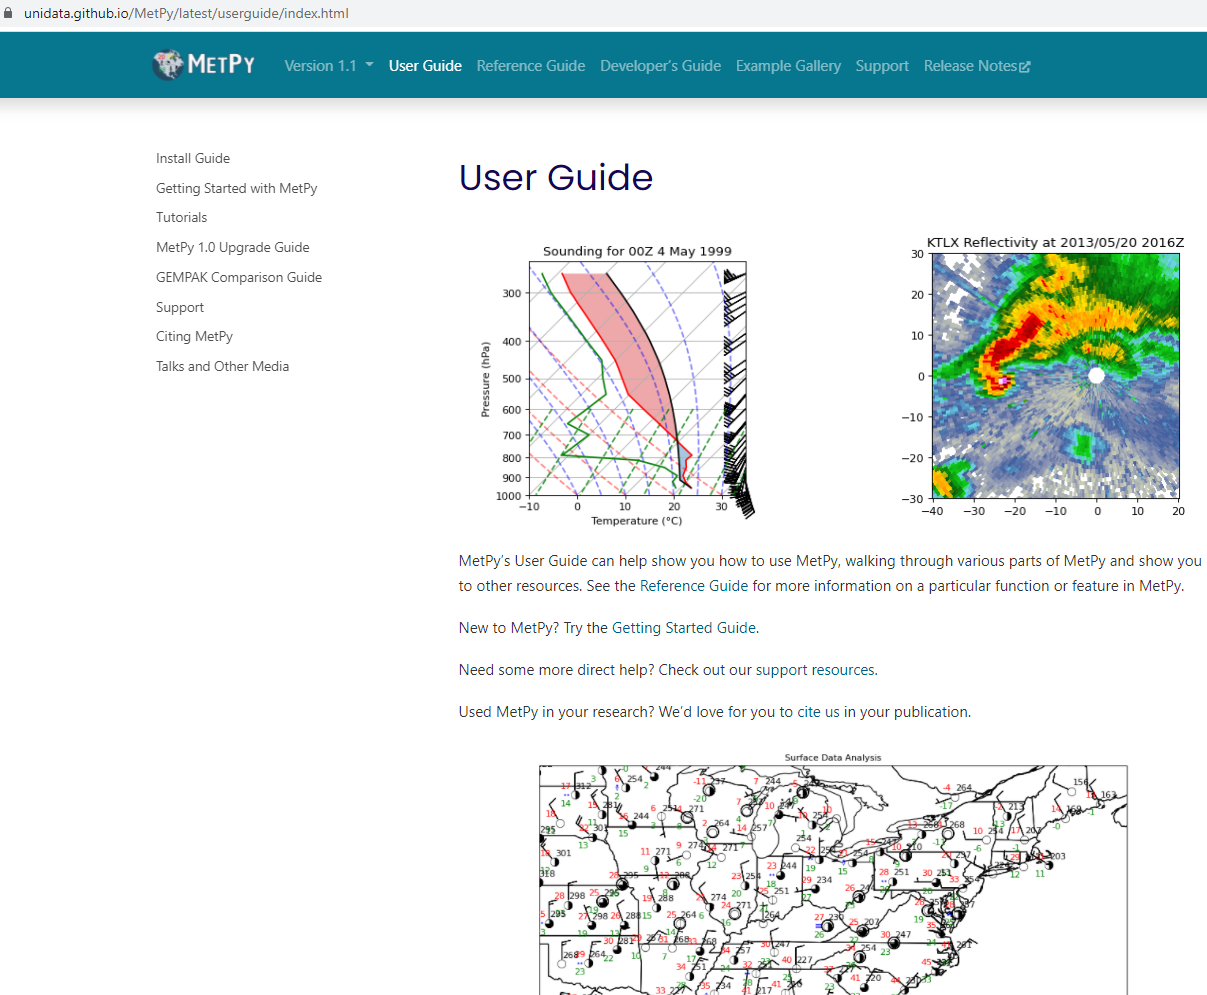

In [ ]:
!pip install metpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 13.0 MB/s eta 0:00:00


# **3° Passo:** Importando Bibliotecas

In [ ]:
# Exemplo: import nome_biblioteca as apelido

import numpy as np                                           # biblioteca para trabalhar com matrizes
from datetime import datetime                                # biblioteca para trabalhar com datas

from siphon.simplewebservice.wyoming import WyomingUpperAir  # biblioteca siphon para baixar os dados de radiossodagens

from metpy.units import units                                # função unidades do metpy
import metpy.calc as mpcalc                                  # função que calcula variáveis termodinâmicas do metpy
from metpy.plots import Hodograph                            # função que plota hodrágrafa do metpy
from metpy.plots import SkewT                                # função que plota o gráfico Skew-T do metpy

import matplotlib.pyplot as plt                              # biblioteca para plotar gráficos
import matplotlib.gridspec as gridspec                       # função do matplotlib para plotar várias sub-figuras em uma figura
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # função do matplotlib para inserir eixos em uma figura

# **4° Passo:** Montando drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **5° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**
- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula.

In [ ]:
# nome do diretório
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/1_PRIMEIRO_SEMESTRE/CAT212 - MICROFÍSICA DE NUVENS E ELETRICIDADE ATMOSFÉRICA/AULAS/CAT212 - PYTHON PARA METEOROLOGIA FÍSICA/AULA_01_RADIOSSONDAGENS'

In [ ]:
# cria a pasta de saídade com o nome "output"
import os
os.makedirs(f'{dir}/output/', exist_ok=True)

# **6° Passo:** Declarando a função

* Função que baixa e plota os dados de uma radissondagem

In [ ]:
def plotar_painel(p, t, td, niveis, nome_estacao, hora, seu_nome, dir):

  pressao = p
  temperatura = t
  orvalho = td

  lcl_pressao, lcl_temperatura = mpcalc.lcl(pressao[0], temperatura[0], orvalho[0])  # calculando LCL
  lfc_pressao, lfc_temperatura = mpcalc.lfc(pressao, temperatura, orvalho)           # calculando LFC
  el_pressao, el_temperatura = mpcalc.el(pressao, temperatura, orvalho)              # calculando EL

  sbcape, sbcin = mpcalc.surface_based_cape_cin(pressao, temperatura, orvalho)       # calculando CAPE e CINE
  agua_precipitavel = mpcalc.precipitable_water(pressao, orvalho)                    # calculando ÁGUA PRECIPITÁVEL
  showalter = mpcalc.showalter_index(pressao, temperatura, orvalho)                  # calculando ÍNDICE SHOWALTER

  # criando a moldura da figura
  fig = plt.figure(figsize=(9, 9))

  # gridspec
  gs = gridspec.GridSpec(3, 3)
  skew = SkewT(fig, rotation=45, subplot=gs[0:2, :2])

  # temperaturas e barbelas de vento
  skew.plot(pressao, temperatura, color='red',)
  skew.plot(pressao, orvalho, color='green')
  skew.plot_barbs(pressao[niveis], vento_u[niveis], vento_v[niveis])

  # adicionar linhas relevantes no skew-t
  skew.plot_dry_adiabats()
  skew.plot_moist_adiabats()
  skew.plot_mixing_lines()

  # calcular o perfil da parcela de ar
  perfil = mpcalc.parcel_profile(pressao, temperatura[0], orvalho[0]).to('degC')
  skew.plot(pressao, perfil, color='black', linewidth=2)

  # cape e cin
  skew.shade_cin(pressao, temperatura, perfil, orvalho)
  skew.shade_cape(pressao, temperatura, perfil)

  # realçar isoterma de 0 degC
  skew.ax.axvline(0, color='cyan', linestyle='--')

  # ajuste do skew-t
  skew.ax.set_xlim(-30, 40)

  # legendas dos eixos
  plt.xlabel(r'Temperatura ($\degree$C)', fontsize=14)
  plt.ylabel(r'Pressão (hPa)', fontsize=14)
  plt.title(f'{nome_estacao}', fontsize=20, loc='left')
  plt.title(f'{hora} UTC', fontsize=15, loc='center')

  # incluir hodógrafo
  ax = fig.add_subplot(gs[0:1, -1])
  hodografo = Hodograph(ax, component_range=80.)
  hodografo.add_grid(increment=10)
  hodografo.plot_colormapped(vento_u[niveis], vento_v[niveis], pressao[niveis],
                           cmap='BuPu_r')
  hodografo.wind_vectors(vento_u[niveis], vento_v[niveis])

  # retirar ticks dos eixos
  #ax.set_xticks([])
  #ax.set_yticks([])

  # colocar limites em x e y
  ax.set_xlim(-40, 40)
  ax.set_ylim(-40, 40)

  # parâmetros termodinâmicos
  ax3 = fig.add_subplot(gs[1, -1])
  ax3.axis('off')

  # coluna 1
  ax3.text(0.1, 1,'Nível do LCL', size = 12)
  ax3.text(0.1, 0.9,'Temp. do LCL', size = 12)
  ax3.text(0.1, 0.8,'Nível do LFC', size = 12)
  ax3.text(0.1, 0.7,'Temp. do LFC', size = 12)
  ax3.text(0.1, 0.6,'EL', size = 12)
  ax3.text(0.1, 0.5,'SBCAPE', size = 12)
  ax3.text(0.1, 0.4,'SBCIN', size = 12)
  ax3.text(0.1, 0.3,'Água Precip.', size = 12)
  ax3.text(0.1, 0.2,'Showalter', size = 12)

  # coluna 2
  ax3.text(0.7, 1, '{:.2f} hPa'.format(np.array(lcl_pressao)), size = 12)
  ax3.text(0.7, 0.9, '{:.2f} C'.format(np.array(lcl_temperatura)), size = 12)
  ax3.text(0.7, 0.8, '{:.2f} hPa'.format(np.array(lfc_pressao)), size = 12)
  ax3.text(0.7, 0.7, '{:.2f} C'.format(np.array(lfc_temperatura)), size = 12)
  ax3.text(0.7, 0.6, '{:.2f} hPa'.format(np.array(el_pressao)), size = 12)
  ax3.text(0.7, 0.5, '{:.2f} J/kg'.format(np.array(sbcape)), size = 12)
  ax3.text(0.7, 0.4, '{:.2f} J/kg'.format(np.array(sbcin)), size = 12)
  ax3.text(0.7, 0.3, '{:.2f} mm'.format(np.array(agua_precipitavel)), size = 12)
  ax3.text(0.7, 0.2, '{:.2f}'.format(np.array(showalter)[0]), size = 12)
  ax3.text(0.1, 0.01, 'Elaborado por: ' + seu_nome, size = 12)

  plt.tight_layout()

  plt.savefig(f'{dir}/output/skewt_{nome_estacao}_{hora}.png', dpi=300, bbox_inches='tight')

  plt.show()

# **PARTE 1):**  Insira a **data** e **sigla** da estação
**### FAZER AS MUDANÇAS AQUI ###**:


**SIGLA DA ESTAÇÃO**

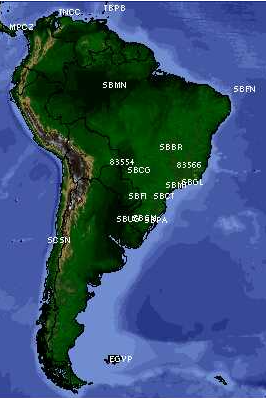

In [ ]:
nome_estacao = 'SBMT'

# Exemplos de estações com sigla e código
# Rio de Janeiro.......: SBGL ou 83746
# São Paulo............: SBMT ou 83779
# Brasília.............: SBBR ou 83378
# Curitiba.............: SBCT ou 83840
# Florianópolis........: SBFL ou 83899
# Uberlândia...........: SBUL ou 83525
# Foz do Iguaçú........: SBFI ou 83827
# Natal................: SBNT ou 82599
# Campo Grande.........: SBCG ou 83612
# Santa Maria..........: SBSM ou
# Porto Velho..........: SBPV ou
# Fernando de Noronha..: SBFN ou

**DATA**

In [ ]:
ano = 2025
mes = 3
dia = 19
hor = 12

# **PARTE 2):** Baixando os dados

**Baixando os dados da radiossondagem em formato de tabela (DataFrame)**

In [ ]:
# exibe a data escolhida
print(ano, mes, dia, hor)

2025 3 19 12


In [ ]:
# exibe a sigla da estação
print(nome_estacao)

SBMT


In [ ]:
df_estacao = WyomingUpperAir.request_data(datetime(ano, mes, dia, hor), nome_estacao)

**Exibindo a tabela de dados**

In [ ]:
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,934.0,722.0,22.6,19.4,110.0,3.0,-2.819078,1.026060,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
1,925.0,800.0,21.0,18.0,115.0,6.0,-5.437847,2.535710,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
2,903.0,1009.0,19.0,17.6,126.0,6.0,-4.854102,3.526712,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
3,850.0,1528.0,16.2,13.7,155.0,6.0,-2.535710,5.437847,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
4,813.0,1906.0,13.0,13.0,183.0,7.0,0.366352,6.990407,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,27.3,24366.0,-56.9,-85.9,83.0,18.0,-17.865831,-2.193648,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
82,27.0,24435.0,-57.0,-85.9,85.0,18.0,-17.931505,-1.568803,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
83,25.0,24921.0,-57.8,-86.2,110.0,36.0,-33.828934,12.312725,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
84,23.4,25338.0,-58.5,-86.5,106.0,38.0,-36.527944,10.474220,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78


**Exibindo uma coluna da tabela de dados**

In [ ]:
df_estacao['dewpoint']

,dewpoint
0,19.4
1,18.0
2,17.6
3,13.7
4,13.0
...,...
81,-85.9
82,-85.9
83,-86.2
84,-86.5


**Plotando gráfico:** temperatura do ar

<Axes: >

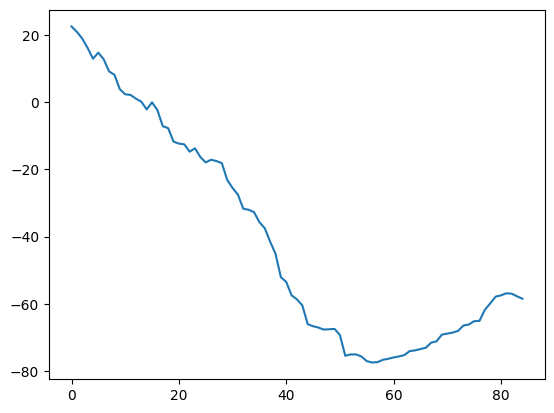

In [ ]:
# plotando de maneira simples
df_estacao['temperature'].plot()

plotando a figura de forma mais completa

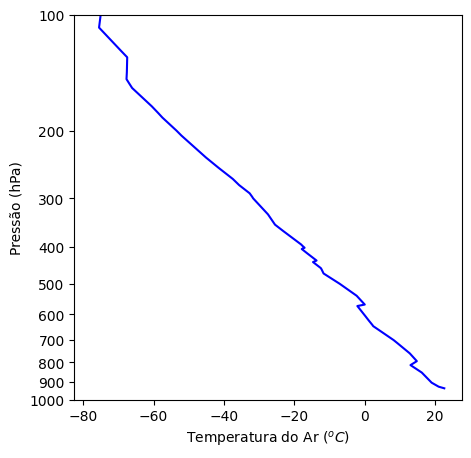

In [ ]:
# importa biblioteca que configura a formatação e localização dos números nos eixos
from matplotlib.ticker import (MultipleLocator, NullFormatter, ScalarFormatter)

# configuração da moldura da figura
fig, ax = plt.subplots(figsize=(5, 5))

# perfil de temperatura
ax.semilogy(df_estacao['temperature'], df_estacao['pressure'], color='blue')

# formatação dos eixos
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())

# ticks no eixo y
ax.set_yticks(np.linspace(100, 1000, 10))

# limite em y (limitando o limite do Skew-T)
ax.set_ylim(100, 1000)

# inverte o eixo y
plt.gca().invert_yaxis()

# nomes dos eixos
ax.set_ylabel('Pressão (hPa)')
ax.set_xlabel('Temperatura do Ar ($^{o}C$)')

# mostra a figura na tela
plt.show()

# **PARTE 4):** Tratamento dos dados

**Eliminando dados NaN (*Not A Number* = Não é número)**

In [ ]:
# mostrando a tabela original
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,934.0,722.0,22.6,19.4,110.0,3.0,-2.819078,1.026060,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
1,925.0,800.0,21.0,18.0,115.0,6.0,-5.437847,2.535710,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
2,903.0,1009.0,19.0,17.6,126.0,6.0,-4.854102,3.526712,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
3,850.0,1528.0,16.2,13.7,155.0,6.0,-2.535710,5.437847,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
4,813.0,1906.0,13.0,13.0,183.0,7.0,0.366352,6.990407,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,27.3,24366.0,-56.9,-85.9,83.0,18.0,-17.865831,-2.193648,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
82,27.0,24435.0,-57.0,-85.9,85.0,18.0,-17.931505,-1.568803,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
83,25.0,24921.0,-57.8,-86.2,110.0,36.0,-33.828934,12.312725,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
84,23.4,25338.0,-58.5,-86.5,106.0,38.0,-36.527944,10.474220,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78


In [ ]:
# retirar "NaN" da tabela
df_estacao = df_estacao.dropna()

In [ ]:
# mostrando a tabela depois de eliminar os dados "NaN"
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,934.0,722.0,22.6,19.4,110.0,3.0,-2.819078,1.026060,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
1,925.0,800.0,21.0,18.0,115.0,6.0,-5.437847,2.535710,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
2,903.0,1009.0,19.0,17.6,126.0,6.0,-4.854102,3.526712,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
3,850.0,1528.0,16.2,13.7,155.0,6.0,-2.535710,5.437847,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
4,813.0,1906.0,13.0,13.0,183.0,7.0,0.366352,6.990407,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,29.0,23984.0,-57.5,-85.9,70.0,16.0,-15.035082,-5.472322,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
81,27.3,24366.0,-56.9,-85.9,83.0,18.0,-17.865831,-2.193648,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
82,27.0,24435.0,-57.0,-85.9,85.0,18.0,-17.931505,-1.568803,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
83,25.0,24921.0,-57.8,-86.2,110.0,36.0,-33.828934,12.312725,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78


In [ ]:
# descrevendo as estatísticas básicas
df_estacao.describe()

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station_number,time,latitude,longitude,elevation,pw
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.0,85,8.500000e+01,8.500000e+01,85.0,8.500000e+01
mean,288.202353,12712.011765,-40.788235,-51.271765,233.447059,27.976471,18.116925,-5.106243,83779.0,2025-03-19 12:00:00,-2.352000e+01,-4.663000e+01,722.0,3.878000e+01
min,23.400000,722.000000,-77.500000,-88.900000,25.000000,3.000000,-36.527944,-33.353981,83779.0,2025-03-19 12:00:00,-2.352000e+01,-4.663000e+01,722.0,3.878000e+01
25%,73.000000,6586.000000,-68.600000,-87.400000,183.000000,11.000000,0.366352,-9.659258,83779.0,2025-03-19 12:00:00,-2.352000e+01,-4.663000e+01,722.0,3.878000e+01
50%,180.000000,13058.000000,-57.000000,-69.100000,275.000000,24.000000,15.563889,-4.330127,83779.0,2025-03-19 12:00:00,-2.352000e+01,-4.663000e+01,722.0,3.878000e+01
75%,455.000000,18406.000000,-12.500000,-15.600000,290.000000,40.000000,31.112698,2.083778,83779.0,2025-03-19 12:00:00,-2.352000e+01,-4.663000e+01,722.0,3.878000e+01
max,934.000000,25338.000000,22.600000,19.400000,350.000000,77.000000,76.706992,12.312725,83779.0,2025-03-19 12:00:00,-2.352000e+01,-4.663000e+01,722.0,3.878000e+01
std,260.861095,7143.501177,32.293462,37.949806,88.633073,20.694476,27.238210,10.946565,0.0,NaN,1.429519e-14,7.862356e-14,0.0,5.718077e-14


In [ ]:
# selecionando as linhas com temperaturas < 29,2oC
df_estacao_novo = df_estacao[ df_estacao['temperature'] > 10]

In [ ]:
# mostrando a tabela
df_estacao_novo

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,934.0,722.0,22.6,19.4,110.0,3.0,-2.819078,1.026060,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
1,925.0,800.0,21.0,18.0,115.0,6.0,-5.437847,2.535710,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
2,903.0,1009.0,19.0,17.6,126.0,6.0,-4.854102,3.526712,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
3,850.0,1528.0,16.2,13.7,155.0,6.0,-2.535710,5.437847,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
4,813.0,1906.0,13.0,13.0,183.0,7.0,0.366352,6.990407,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
5,794.0,2106.0,14.8,10.1,197.0,8.0,2.338974,7.650438,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78
6,758.0,2497.0,12.8,3.8,226.0,9.0,6.474058,6.251925,SBMT,83779,2025-03-19 12:00:00,-23.52,-46.63,722.0,38.78


In [ ]:
# mostrando o tipo do objeto "tabela"
type(df_estacao_novo)

pandas.core.frame.DataFrame

**Atribuindo as variáveis que serão utilizadas e inserindo unidades nos dados**
- **Values**: tranforma de DataFrame para vetor (array unidimensional)

In [ ]:
df_estacao['pressure']

,pressure
0,934.0
1,925.0
2,903.0
3,850.0
4,813.0
...,...
80,29.0
81,27.3
82,27.0
83,25.0


In [ ]:
df_estacao['pressure'].values

array([934. , 925. , 903. , 850. , 813. , 794. , 758. , 712. , 700. ,
       658. , 644. , 640. , 622. , 607. , 571. , 566. , 537. , 500. ,
       496. , 470. , 458. , 455. , 439. , 435. , 417. , 406. , 403. ,
       400. , 395. , 365. , 351. , 330. , 300. , 297. , 291. , 277. ,
       267. , 250. , 235. , 206. , 200. , 185. , 180. , 173. , 155. ,
       152. , 150. , 147. , 141. , 129. , 124. , 108. , 101. , 100. ,
        98. ,  93. ,  91.7,  91. ,  87. ,  85. ,  83. ,  81. ,  79. ,
        73. ,  72. ,  70. ,  68. ,  61. ,  59. ,  51. ,  50. ,  49. ,
        47. ,  42. ,  41. ,  38. ,  37.8,  34. ,  32. ,  30. ,  29. ,
        27.3,  27. ,  25. ,  23.4])

In [ ]:
# registrando unidades
pressao = df_estacao['pressure'].values * units('hPa')
temperatura = df_estacao['temperature'].values * units('celsius')
orvalho = df_estacao['dewpoint'].values * units('celsius')
vento_u = df_estacao['u_wind'].values * units('m/s')
vento_v = df_estacao['v_wind'].values * units('m/s')

In [ ]:
# mostrando os valores de PRESSÃO
pressao

Magnitude,[934.0 925.0 903.0 850.0 813.0 794.0 758.0 712.0 700.0 658.0 644.0 640.0 622.0 607.0 571.0 566.0 537.0 500.0 496.0 470.0 458.0 455.0 439.0 435.0 417.0 406.0 403.0 400.0 395.0 365.0 351.0 330.0 300.0 297.0 291.0 277.0 267.0 250.0 235.0 206.0 200.0 185.0 180.0 173.0 155.0 152.0 150.0 147.0 141.0 129.0 124.0 108.0 101.0 100.0 98.0 93.0 91.7 91.0 87.0 85.0 83.0 81.0 79.0 73.0 72.0 70.0 68.0 61.0 59.0 51.0 50.0 49.0 47.0 42.0 41.0 38.0 37.8 34.0 32.0 30.0 29.0 27.3 27.0 25.0 23.4]
Units,hectopascal


In [ ]:
# mostrando os valores de TEMPERATURA
temperatura

Magnitude,[22.6 21.0 19.0 16.2 13.0 14.8 12.8 9.2 8.2 3.9 2.4 2.2 1.1 0.2 -2.1 0.0 -2.3 -7.1 -7.7 -11.7 -12.3 -12.5 -14.7 -13.7 -16.3 -17.9 -17.1 -17.5 -18.1 -23.1 -25.5 -27.5 -31.7 -32.0 -32.7 -35.7 -37.5 -41.5 -45.1 -52.1 -53.5 -57.5 -58.7 -60.5 -66.1 -66.7 -67.1 -67.7 -67.6 -67.5 -69.3 -75.5 -75.1 -75.1 -75.7 -77.1 -77.5 -77.4 -76.7 -76.4 -76.0 -75.7 -75.3 -74.1 -73.9 -73.5 -73.1 -71.6 -71.2 -69.2 -68.9 -68.6 -68.1 -66.5 -66.2 -65.2 -65.1 -61.8 -59.9 -57.9 -57.5 -56.9 -57.0 -57.8 -58.5]
Units,degree_Celsius


In [ ]:
# mostrando os valores de TEMPERATURA DO PONTO DE ORVALHO
orvalho

Magnitude,[19.4 18.0 17.6 13.7 13.0 10.1 3.8 3.9 3.9 2.3 1.7 1.2 -1.1 -3.1 -8.1 -10.0 -13.3 -15.1 -15.6 -18.7 -14.6 -13.5 -14.7 -17.6 -19.7 -21.0 -21.4 -22.1 -24.1 -28.0 -29.9 -27.5 -32.4 -33.6 -36.0 -36.9 -43.5 -45.0 -48.7 -69.1 -69.5 -62.5 -65.0 -68.5 -70.7 -73.9 -76.1 -75.7 -77.9 -82.5 -83.2 -85.5 -86.1 -87.1 -87.2 -87.4 -87.5 -87.5 -87.7 -87.8 -87.9 -88.0 -88.0 -88.3 -88.4 -88.5 -88.5 -88.7 -88.7 -88.9 -88.9 -88.8 -88.7 -88.4 -88.3 -88.1 -88.1 -87.1 -86.5 -85.9 -85.9 -85.9 -85.9 -86.2 -86.5]
Units,degree_Celsius


In [ ]:
# mostrando os valores de VENTO ZONAL
vento_u

Magnitude,[-2.8190778623577253 -5.4378467222199 -4.854101966249685 -2.535709570444197 0.36635169370060494 2.338973637781894 6.474058203047861 9.961946980917455 13.946725773284438 15.75692404819533 13.923306535155827 13.787308542170912 14.095389311788624 21.0 24.90486745229364 25.85756927957511 28.559424837354037 19.659649062935802 19.659649062935802 21.650635094610966 23.635386072292995 24.620193825305204 26.58980933132962 27.574617084341828 30.52904034337845 24.432008140433616 24.106780218736475 24.47031024998955 26.492818271635432 38.63703305156274 42.01111919237408 46.76537180435968 31.112698372208097 31.112698372208097 33.089630815577955 37.735479011138615 41.18873595721945 47.51081856876152 54.74275075725348 69.1802745997517 71.8909659698912 75.58366404798878 76.7069917530644 75.81486781974665 71.98903405126018 71.0 67.7412394702387 64.51549985668593 58.10365742772027 41.228341704801885 31.949549106720884 40.37711787350053 23.49231551964771 15.56388884149084 8.030070108914646 6.973362886642219 9.81627183447664 10.336618828644992 19.696155060244163 10.625184089179752 4.015035054457325 1.9101299543362342 2.778370842670886 10.9581416790092 9.659258262890683 4.499513267805774 -9.969385657403151 -15.407232379623048 -7.071067811865475 -6.4278760968653925 -3.3809460939255955 2.500000000000002 2.588190451025207 -11.817693036146496 -19.91858428704209 -27.574617084341824 -26.66758519606872 -12.216004070216808 -13.856406460551018 -16.741731801207536 -15.035081932574533 -17.865830729543795 -17.93150456565142 -33.828934348292705 -36.52794444565612]
Units,meter/second


In [ ]:
# mostrando os valores de VENTO MERIDIONAL
vento_v

Magnitude,[1.0260604299770062 2.535709570444196 3.5267115137548384 5.437846722219899 6.9904067432820165 7.6504380477042835 6.251925334130975 0.8715574274765825 1.2201803984672155 -2.7783708426708795 1.4633984857471471 2.4310744873370247 -5.1303021498850345 3.857637417314163e-15 -2.1788935686914472 -2.7177400449589775 -5.035797152340969 -13.765834472425105 -13.765834472425105 -12.500000000000004 -4.167556264006319 -4.341204441673249 -4.6885007970071095 -4.862148974674039 -5.383093507674829 -8.892523726467394 -9.739771428813711 -11.41069306699889 -11.795362649198193 -10.352761804100812 -16.12655772953852 -27.000000000000007 -31.112698372208083 -31.112698372208083 -31.954285041113874 -32.80295144952535 -33.353980725641385 -33.26743330836067 -29.107236892725204 -15.971524858414408 -12.676316969685887 -7.944163208341627 -6.710992191569657 -5.301492004553516 -1.2565732634843854 1.304248841091931e-14 5.9265905068407605 7.921507321334566 10.245242482348889 -8.013977805814894 -11.628684873072746 -7.119575284344129 8.550503583141714 10.897952290669881 11.468128620045885 0.6100901992336077 -1.908089953765451 -3.762221576582359 -3.4729635533385994 -2.8470094961277232 -5.734064310022941 -10.832885283134289 -15.756924048195328 0.9587131702242407 2.5881904510252065 5.362311101832846 4.648800879147693 -7.18451044959189 -7.0710678118654755 -7.66044443118978 -7.2504622962931995 -4.330127018922192 -9.659258262890683 2.0837781320031636 11.499999999999995 4.8621489746740485 4.223730556086232 -4.446261863233695 -8.000000000000002 -2.952019020337817 -5.472322293210701 -2.1936481812926547 -1.5688033694578465 12.312725159724074 10.474219521045963]
Units,meter/second


**Criando um intervalo de níveis de pressão através de `np.arange()` entre os níveis de `1000 hPa a 100 hPa`**

In [ ]:
np.arange(1, 150, 1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149])

In [ ]:
niveis = np.arange(100, 1050, 50) * units('hPa') # hectopascal
niveis

Magnitude,[ 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000]
Units,hectopascal


In [ ]:
# quantidade de pontos da variável "niveis"
len(niveis)

19

In [ ]:
# mostrando a pressão
pressao

Magnitude,[934.0 925.0 903.0 850.0 813.0 794.0 758.0 712.0 700.0 658.0 644.0 640.0 622.0 607.0 571.0 566.0 537.0 500.0 496.0 470.0 458.0 455.0 439.0 435.0 417.0 406.0 403.0 400.0 395.0 365.0 351.0 330.0 300.0 297.0 291.0 277.0 267.0 250.0 235.0 206.0 200.0 185.0 180.0 173.0 155.0 152.0 150.0 147.0 141.0 129.0 124.0 108.0 101.0 100.0 98.0 93.0 91.7 91.0 87.0 85.0 83.0 81.0 79.0 73.0 72.0 70.0 68.0 61.0 59.0 51.0 50.0 49.0 47.0 42.0 41.0 38.0 37.8 34.0 32.0 30.0 29.0 27.3 27.0 25.0 23.4]
Units,hectopascal


**E esse intervalo de `niveis` vai servir para "filtrar" os dados de vento para o diagrama, com o uso de `mpcalc.resample_nn_1d()`.**

In [ ]:
len(pressao)

85

In [ ]:
len(niveis)

19

In [ ]:
niveis = mpcalc.resample_nn_1d(pressao, niveis)
niveis

[np.int64(53),
 np.int64(46),
 np.int64(40),
 np.int64(37),
 np.int64(32),
 np.int64(30),
 np.int64(27),
 np.int64(21),
 np.int64(17),
 np.int64(16),
 np.int64(13),
 np.int64(10),
 np.int64(8),
 np.int64(6),
 np.int64(5),
 np.int64(3),
 np.int64(2),
 np.int64(0)]

**Extraindo o nome e data da estação**

In [ ]:
# para o título
nome = df_estacao['station'][0]
dia = df_estacao['time'][0]

In [ ]:
nome

'SBMT'

In [ ]:
dia

Timestamp('2025-03-19 12:00:00')

# **PARTE 5):** Plotando o gráfico

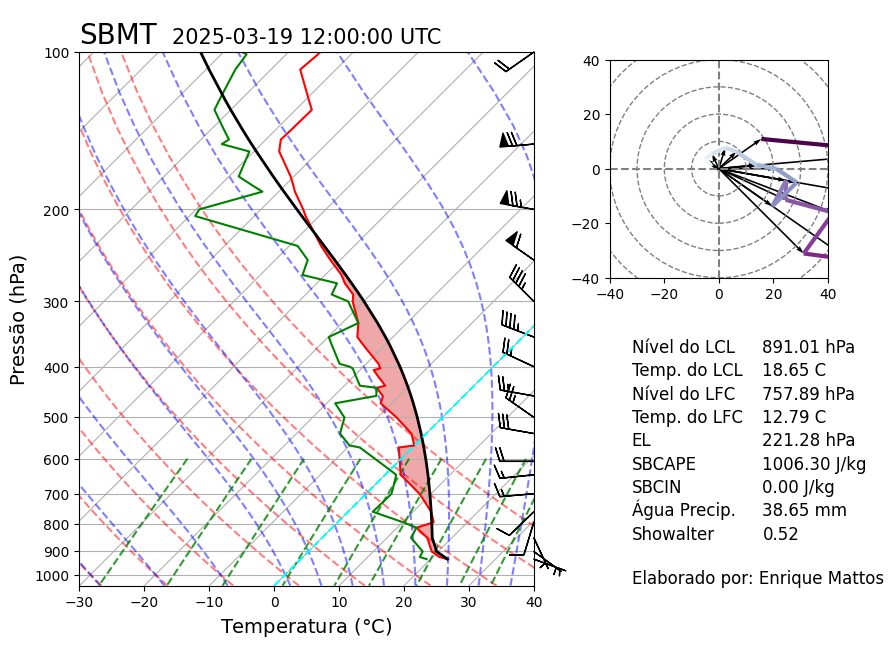

In [ ]:
# plotar painel termodinâmico com a função
plotar_painel(pressao,
              temperatura,
              orvalho,
              niveis,
              nome_estacao,
              dia,
              'Enrique Mattos',
              dir)

Lembrando alguns termos:

 - `LCL`: Lifting Condensation Level
 - `LFC`: Level of Free Convection
 - `LNB`: Level of Neutral Buoyancy

Cálculo do CAPE e CINE: a partir da curva da Temperatura do Ponto de Orvalho (TD) em superfície, a parcela realiza a ascensão através da curva da Razão de Mistura até encontrar a curva da Adiabática Seca. Depois a ascensão da parcela é realizada pela Adiabática Saturada.

- `Showalter (SWI)`: SWI = T500 - Tp500 --> *Valores negativos são indicativos de tempestades*
   - T500: temperatura do ar ambiente em 500mb
   - Tp500: temperatura de uma parcela de ar após ascender do nível de 850mb até 500mb

   
- `Lifter Index (LI)`: LI = T500 - Tp500 --> *Valores negativos são indicativos de tempestades*
   - T500: temperatura do ar ambiente em 500mb
   - Tp500: temperatura de uma parcela de ar após ascender do nível de 1000mb até 500mb

      
- `Índice K (K)`: K = (T850 - T500) + Td850 - (T700-Td700) --> *Valores altos são indicativos de tempestades*
   - T500: temperatura do ar ambiente em 500mb
   - T700: temperatura do ar ambiente em 700mb
   - T850: temperatura do ar ambiente em 850mb
   - Td700: temperatura do ponto de orvalho em 700mb
   - Td850: temperatura do ponto de orvalho em 850mb.
   - **Observação**: Leva em consideração a taxa de queda de temperatura do ambiente (T850-T500), umidade em (Td850) e o grau de secamento (T700-Td700).
   

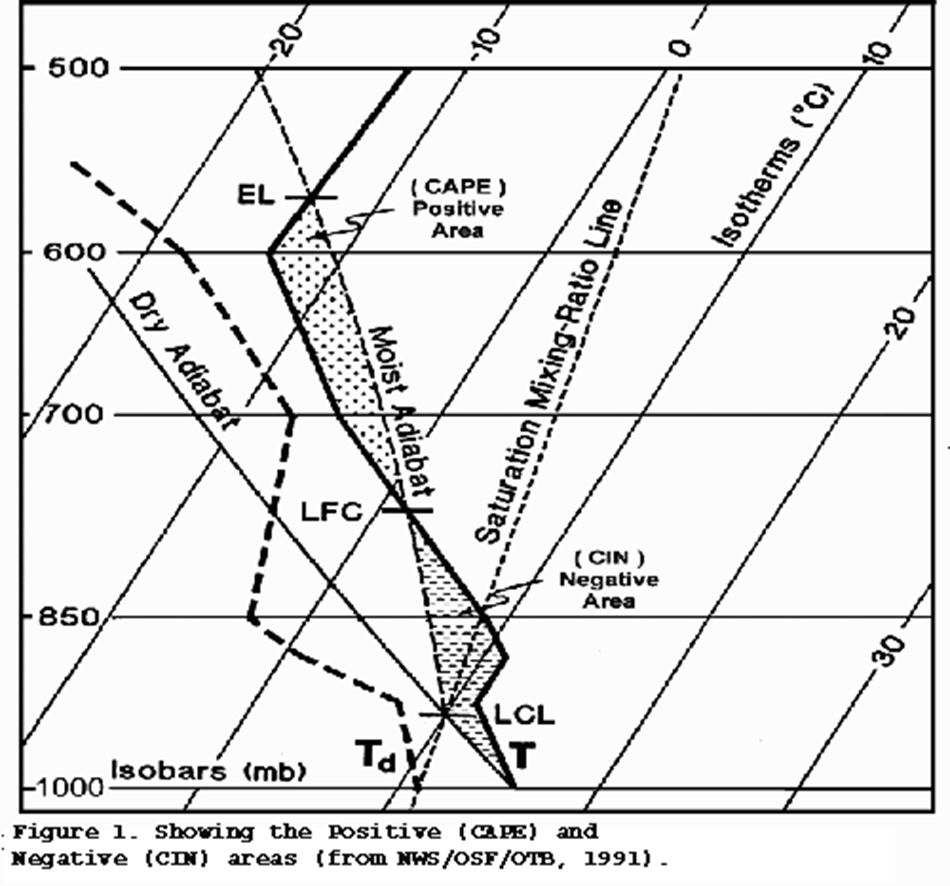

# Segue o link de materiais explicando sobre gráfico `Skew-T Log-P`: [Guia para a Interpretação de Sondagens](https://docs.google.com/presentation/d/1U__lSNhRvpiOYkc4As5uSmsOeDCm5liJ/edit?usp=sharing&ouid=107746204627544224004&rtpof=true&sd=true) e [Análise de condições atmosféricas através de Diagrama Skew-T](https://docs.google.com/presentation/d/1qZtiN6IgWjB3ekQx3OCqwDKYrJYwGUQq/edit?usp=sharing&ouid=107746204627544224004&rtpof=true&sd=true)

# **PARTE 6):** Gerando outros parâmetros meteorológicos e salvando num arquivo `CSV`

- Outro aspecto importante da análise de radiossondagens é o cálculo de algumas variáveis de interesse, como a própria Umidade Relativa (que é colocada na tabela no portal da Wyoming, mas que não é disponibilizada pelo Siphon), Temperatura Potencial e outras.

- O `mpcalc` também possui várias funções para o cálculo dessas variáveis e, novamente a lista é extensa.

- Por exemplo, podemos calcular:
   - Umidade Relativa a partir da Temperatura do Ponto de Orvalho: `.relative_humidity_from_dewpoint()`, que precisa da temperatura do ar e temperatura do ponto de orvalho como argumentos (e precisa multiplicar por 100 ao final).
   

**- Umidade relativa**

In [ ]:
umidade_relativa = mpcalc.relative_humidity_from_dewpoint(temperatura,
                                                          orvalho) * 100
umidade_relativa

Magnitude,[74.03841994399446 80.00358803959111 81.49868870279013 85.05606632730846 91.58638573861703 83.36117203570674 83.36117203570674 80.11794004605315 80.10430544798321 83.8766311008234 85.89770242764601 88.0411410037982 77.04498508716604 76.50981826350204 57.26091861753606 25.05031257646208 61.27503681346869 21.04219954340622 28.872503653570863 60.98311155483616 65.29122673407336 52.0657026235667 46.919107599 36.258480513760446 14.267604103941439 10.022714185007175 7.202973314748997 5.3036400161878845 6.266145066388991 9.486773964753983 5.667999296870323 7.6737533582286925 21.30955181160491 32.30947360055304 72.86640601166887 74.03972473302694 60.318616259316094 80.17305299438392 99.14880619153628 96.62811419891838 94.16137717242896 66.9166039763665 66.89210092707356 74.059585244703 87.6856479256436 30.42758561856751 37.25182038941508 5.018497816755088 3.2493513435794057 55.55755115764622 50.13931563909565 16.23377046542543 10.02998185940077 18.431408222657673 14.883417318376196 10.96563223027726 15.722982579546787 42.59825478791801 54.64679438532044 42.443218246456546 21.94250779480993 21.365101775629824 19.802460015795535 9.150928291011656 9.881763791873666 13.093265769909904 23.00957426288295 26.61576939051991 48.9256182578211 30.029036621828624 29.601045946622428 28.39519509152908 27.788467009457925 27.614688406717068 13.488452775112863 11.983735596665403 12.046468181148882 12.165742850887597 12.287059421547152 12.568252609013664 13.057659925285064 13.471134235009515 13.027247075612344 10.077280081347913 7.070690016724626 6.737638847356993 6.517166003307021 6.00735115311418 5.745393807070771 3.919903069208383 3.4135968384541755 3.0169419333559304 2.6372901047815214 2.182504293179064 1.6760430058376308 1.6678984270295332 1.6436151661980405 1.627551567005571 1.611588012942676 1.5780245966288224 1.4741707859035866 1.4404729200660262 1.317935685664333 1.2092614587968185]
Units,dimensionless


**- Razão de mistura**
- Razão de mistura a partir da Umidade Relativa: `.mixing_ratio_from_relative_humidity()`, cujos argumentos são pressão, temperatura e umidade relativa.

In [ ]:
razao_mistura = mpcalc.mixing_ratio_from_relative_humidity(pressao,
                                                           temperatura,
                                                           umidade_relativa)
razao_mistura

Magnitude,[-1.088175958549693 -1.1201944521447256 -1.1108161935947465 -1.1116290483541966 -1.1196369866453926 -1.1490263994759529 -1.1483648310186076 -1.2130816337379184 -1.2178035713495812 -1.408200908630129 -1.5662541654870519 -1.764694088231286 -3.3765907617791817 -3.4733063342646835 9.50449470568644 0.449976911517614 15.13818039731478 0.3136612984948669 0.5238178146231444 6.284770653169915 6.331994059541145 0.8987123295966838 0.5767813161535923 0.3653881390487764 0.1038064398819484 0.061464011998983104 0.03877808261900823 0.02544483481406209 0.02970047661164109 0.044048709980752616 0.025249632379102913 0.03335535709652132 0.0888338036400934 0.14217784954467722 0.42857026139868526 0.4333229345391616 0.2403971612686013 0.2777274004988006 0.31334076253700366 0.2961523199759607 0.2838622683715917 0.15337203504766903 0.15194985503586253 0.13655768203180466 0.11333265093881366 0.03525959268723362 0.04159291338714916 0.005189841695000286 0.003324175744124165 0.058465521620432274 0.05177095500902355 0.013117147564804758 0.007510238441652061 0.008362695019635304 0.005254276820220631 0.002723784407715357 0.003456847316465923 0.006536579907721959 0.008336569662515446 0.006335523013723135 0.003155650935508997 0.002629413718905428 0.002340864036204216 0.0006348416321377003 0.0006423180704522958 0.0006502332912324639 0.0006841361893266865 0.0007329528045494442 0.0011456800936521284 0.0006357158327247993 0.0005627982103094068 0.0003964668841802458 0.0003305003789260664 0.00031391664371451157 0.00020105358055503628 0.00018682502041003505 0.00019547876489078376 0.00019413115898315217 0.0001917165970211496 0.0001897586709240465 0.00019033409437620047 0.00018512441114179864 0.00018273943711641637 0.00017906116077002864 0.00016889772664871827 0.00017326227777927076 0.0001780925605317236 0.0001855945402968431 0.00018622386270455643 0.00020366912253574356 0.0002100110511637489 0.00025438556143108433 0.00029100921935281223 0.0003544458556024266 0.00046522855545972605 0.00046691166473054164 0.00048165873192406887 0.0004788140531066182 0.0004886044070227984 0.0005006699992612248 0.0005863020050664053 0.0006397217631690943 0.0010417143442492593 0.001559873366245943]
Units,dimensionless


**- Temperatura virtual** `.virtual_temperature()`, cujos argumentos são temperatura e razão de mistura.

In [ ]:
temperatura_virtual = mpcalc.virtual_temperature(temperatura,
                                                 razao_mistura)
temperatura_virtual

Magnitude,[2251.277232357826 1692.6536151144428 1817.4654464967998 1799.3453716420813 1680.876201313844 1392.7075942847728 1398.0354827492324 1029.506825467342 1011.005735612788 618.9036173837716 493.5529269896425 409.09474643923465 252.28775710357945 249.46796429647713 164.17256109398346 62.45960518615402 168.30172848947808 48.80342560985309 66.50258975184988 153.60303329135348 151.92356623530367 80.90360211887571 60.732607884647166 44.19789964757837 14.66253240348982 6.508272272620275 1.2890026123308758 -2.478297612984875 -2.1303297597573874 -0.6875510603765065 -3.9293479008028953 -3.3075920702376607 2.5249203024754934 9.049989579506644 36.44787101159716 36.580543866108144 15.969270824698413 16.61556606709013 17.741701406425477 15.954720204173611 14.701720557886176 -1.3759895353333604 -1.647607545938115 -6.233605085361944 -13.574799164310889 -24.047714935961608 -23.791025564185674 -29.236935409892965 -29.610537604255143 -22.766679141438573 -23.858123790109914 -31.714802217102033 -33.41869875496707 -39.327228098274276 -42.569765184016745 -46.726769667837345 -47.92938885880878 -51.22744554936949 -51.190160248646436 -51.65564591611326 -52.47886866456463 -54.1514629331912 -54.59018958574771 -59.81776440754862 -60.4170306536528 -62.81695683143772 -67.21445838850187 -67.80862613762599 -69.15820601367147 -70.22166730894105 -71.23098903234751 -74.05205117630305 -75.46030769895401 -75.8623750396998 -74.67575307805774 -74.47744600471981 -74.27637774781877 -74.57657595769317 -74.87690219763039 -75.37719570105122 -75.97719596361807 -76.87792127595563 -76.77819456073163 -75.5785028108306 -74.07956881069589 -73.87901987283573 -73.77842426063214 -73.4774817351639 -73.1773714420994 -70.17488074171231 -69.0739583464017 -67.66824082984598 -66.1634045728847 -63.954956215510265 -60.840008037341164 -60.939819465986346 -61.23800740990404 -61.438431542720906 -61.637232630272706 -61.335592178373275 -59.82404840945725 -59.21689949781265 -56.062773770541014 -53.29206641524473]
Units,degree_Celsius


**- Temperatura potencial equivalente**

In [ ]:
temperatura_potencial_equiv = mpcalc.equivalent_potential_temperature(pressao,
                                                                      temperatura,
                                                                      orvalho)
temperatura_potencial_equiv

Magnitude,[346.9313088125186 343.51764892293977 344.1711860801117 344.22142420377645 344.0415370159152 344.99549256886405 345.0933756875697 345.03002153825474 344.9860478356548 342.3734133577902 340.8409315067342 339.7657177447717 334.804538027562 334.72607778262955 331.099880928467 322.07838303533487 332.55062197285116 321.86649422817516 324.7475494761678 333.27619900301346 333.30367805632085 328.35324938459286 326.66710474459876 325.12916935938017 322.71213308647 323.13874129847875 323.8396892995999 324.5305136598816 324.7111884425204 325.3909582385927 325.97538936478406 326.4058365729659 328.75692017642575 330.2194096350414 335.34081911140635 335.76622364535746 334.9566748517496 336.0558610673648 337.0249945011749 336.9781350833815 337.183936611775 339.4186632138423 339.40993587149813 339.5750314213288 339.76421624687487 340.83384401476656 341.1416647614306 340.16652725073703 340.10502193619175 342.85995898717607 343.33933442059794 343.8211950735498 344.3657599190888 346.081660410178 346.7509721045749 347.63173052693827 347.9217469197701 348.41962099111385 349.6564998677258 349.75413836808616 350.493184093342 351.53893223473773 351.73166036956235 352.65412580840615 352.8393849363623 353.1978143404694 353.9939087216018 353.6396637096408 354.68929542916834 357.24275087978526 359.2461292227692 364.9937785464518 367.78300688742536 368.713627577961 380.4649304451465 382.4551283446034 383.9306180907308 386.47454425154547 388.42288795424594 392.2344862140629 397.40963367217927 404.7239973889063 405.5148245495909 414.0950512751083 425.54500340207346 431.33743972212835 437.2397482785369 447.7617831101045 448.8684440457013 460.11573321105146 464.2461699452922 483.5552312438564 495.7760630664993 513.9479734813386 541.1399843783838 544.2010801156251 556.721637452886 560.9601772945934 569.4845597889433 571.3423897720205 580.8130328179356 588.1210256332336 629.832616156208 668.0301780254332]
Units,kelvin


**- Unindo os parâmetros calculados as variáveis originais**

In [ ]:
df_estacao.insert(4, 'Umidade Relativa', umidade_relativa)
df_estacao.insert(5, 'Temperatura Virtual', temperatura_virtual)
df_estacao.insert(6, 'Temperatura Potencial Eq.', temperatura_potencial_equiv)

In [ ]:
df_estacao

,pressure,height,temperature,dewpoint,Umidade Relativa,Temperatura Virtual,Temperatura Potencial Eq.,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,935.0,722.0,23.8,18.9,74.038420,2251.277232,346.931309,100.0,2.0,-1.969616,3.472964e-01,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
1,929.0,777.0,21.8,18.2,80.003588,1692.653615,343.517649,91.0,3.0,-2.999543,5.235722e-02,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
2,925.0,813.0,21.6,18.3,81.498689,1817.465446,344.171186,85.0,3.0,-2.988584,-2.614672e-01,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
3,914.3,914.0,20.7,18.1,85.056066,1799.345372,344.221424,95.0,3.0,-2.988584,2.614672e-01,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
4,894.0,1108.0,19.0,17.6,91.586386,1680.876201,344.041537,25.0,9.0,-3.803564,-8.156770e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,31.0,23586.0,-61.4,-88.6,1.578025,-61.335592,571.342390,80.0,21.0,-20.680963,-3.646612e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
100,30.0,23790.0,-59.9,-87.9,1.474171,-59.824048,580.813033,100.0,22.0,-21.665771,3.820260e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
101,29.0,24005.0,-59.3,-87.6,1.440473,-59.216899,588.121026,105.0,24.0,-23.182220,6.211657e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
102,24.0,25204.0,-56.2,-85.9,1.317936,-56.062774,629.832616,90.0,41.0,-41.000000,-2.510526e-15,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59


**- Renomeando as colunas da tabela**

In [ ]:
df_estacao.columns = ['Pressao Atm (hPa)',
                      'Altura (m)',
                      'Temperatura (C)',
                      'Temperatura Pto. de Orvalho (C)',
                      'Umidade Relativa (%)',
                      'Temperatura Virtual (K)',
                      'Temperatura Potencial Eq. (K)',
                      'Direcao do Vento',
                      'Velocidade (m/s)',
                      'Vento Zonal (m/s)',
                      'Vento Meridional (m/s)',
                      'Estacao',
                      'Codigo',
                      'Tempo',
                      'Latitude',
                      'Longitude',
                      'Elevacao',
                      'Agua Precipitavel']

In [ ]:
df_estacao

,Pressao Atm (hPa),Altura (m),Temperatura (C),Temperatura Pto. de Orvalho (C),Umidade Relativa (%),Temperatura Virtual (K),Temperatura Potencial Eq. (K),Direcao do Vento,Velocidade (m/s),Vento Zonal (m/s),Vento Meridional (m/s),Estacao,Codigo,Tempo,Latitude,Longitude,Elevacao,Agua Precipitavel
0,935.0,722.0,23.8,18.9,74.038420,2251.277232,346.931309,100.0,2.0,-1.969616,3.472964e-01,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
1,929.0,777.0,21.8,18.2,80.003588,1692.653615,343.517649,91.0,3.0,-2.999543,5.235722e-02,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
2,925.0,813.0,21.6,18.3,81.498689,1817.465446,344.171186,85.0,3.0,-2.988584,-2.614672e-01,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
3,914.3,914.0,20.7,18.1,85.056066,1799.345372,344.221424,95.0,3.0,-2.988584,2.614672e-01,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
4,894.0,1108.0,19.0,17.6,91.586386,1680.876201,344.041537,25.0,9.0,-3.803564,-8.156770e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,31.0,23586.0,-61.4,-88.6,1.578025,-61.335592,571.342390,80.0,21.0,-20.680963,-3.646612e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
100,30.0,23790.0,-59.9,-87.9,1.474171,-59.824048,580.813033,100.0,22.0,-21.665771,3.820260e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
101,29.0,24005.0,-59.3,-87.6,1.440473,-59.216899,588.121026,105.0,24.0,-23.182220,6.211657e+00,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59
102,24.0,25204.0,-56.2,-85.9,1.317936,-56.062774,629.832616,90.0,41.0,-41.000000,-2.510526e-15,SBMT,83779,2025-03-18 12:00:00,-23.52,-46.63,722.0,36.59


**- Salvando em um `DataFrame`**

In [ ]:
df_estacao.to_csv(f'{dir}/output/{nome_estacao}_{dia}.csv', sep=';')